<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_S24/blob/master/07_Furkan_Pyro_Framework_for_Heat_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\\

# **Pyro framework for parameters estimation using MCMC-NUTS algorthim Applied to the 1D Heat problem**

**1D Heat equation ODE:**

The heat equation, also known as the diffusion equation, is a fundamental partial differential equation that describes the distribution of heat over time in a given region. It is often denoted as:

$$
\frac{\partial u(x,t)}{\partial t} = \kappa \frac{\partial^2 u(x,t)}{\partial x^2}
$$

Where:
$\frac{\partial u}{\partial t}$  represents the rate of change of temperature with respect to time.
$\kappa$ is the thermal diffusivity of the material.
$\frac{\partial^2 u(x,t)}{\partial x^2}$ represents the spatial second derivative.
$u$ is the temperature field, which depends on both time ($t$) and spatial coordinates ($x, y, z$).

**Objective:**\
It's required to estimate $\kappa$ by Baysian inference using Markov Chain Monte Carlo (MCMC)algorthim. Specifically the No U-Turn Sampler (NUTS) inside *`Pyro`* packages.

**Installing Pyro** **:**

In [1]:
!pip3 install pyro-ppl  # Instaling Pyro Packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

**Importing required libraries/packages** **:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS, Predictive

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


**Inputs:**\
The time step ($dt = 0.0001$) , the spatial domain ($x$ $ϵ$ $[0,1] $), spatial step ($dx = 1 / n_{x}$), where $n_{x} = 64 $ is the number of spatial points.

Initial conditions:\
$u(x,0) = sin(\pi x)$ \

Boundary conditions:\
$u(0,t) = 0.0$ and $u(1,t) = 0.0$ \

Final time:\
$t_f = 0.2 sec$

Number of time steps:\
$n_t = t_f / dt$

In [3]:
#Inputs
nx = 64;      # number of spatial points
dx = 1/nx;    # spatial step
x = np.linspace(0,1,nx+1)  # the spatial domain
dt = 0.0001   # time step
tend = 0.2;           # final time
ttend = tend/dt       # numer of time steps
kappa_true = 1 # assumed to be known to generate data, eventutally the estimated kappa should be indetical to the true one.
u0 = np.sin(np.pi*x)  # initial conditions

**Heat equation spatial discretization function:**\
Here we discritize heat equation ODE using central finite difference in spatial domain, i.e,\
$\frac{\partial u}{\partial t} = \kappa* \frac{ u_{i+1}-2u_i +u_{i-1}}{Δx^2} $

In [4]:
# Heat Equation discretized ODE Function
def heat(u,nx,dx,kappa):
    rhs = np.zeros(nx+1)
    idx = np.arange(1,nx)
    for i in idx:
        rhs[i] = (1/dx**2)*(u[i+1]-2*u[i]+u[i-1])*kappa  # Central Finite Difference
    return rhs

**Data generation:**

Here we generate synthetic data from the analytical solution, if the analytical solution doesn't exist, which normally that's the case, we solve the system using $4th$ order runge kutta numerical integration.

For demonstration, The system will be solved numerically and analytically.

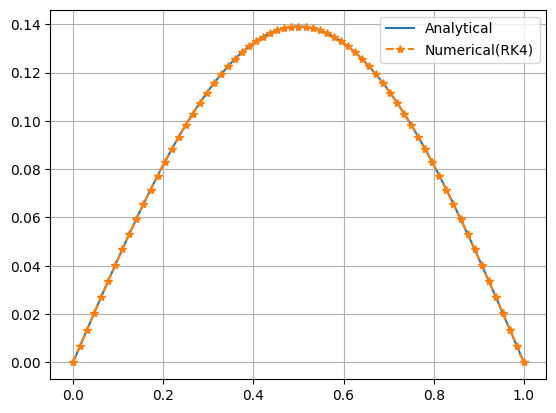

In [5]:
# Generating data: Numerical and analytical solution of heat equation

u = u0
for tt in range(int(ttend)):
    k1 = heat(u,nx,dx,kappa_true)
    k2 = heat(u+k1*dt/2,nx,dx,kappa_true)
    k3 = heat(u+2*k2*dt-k1*dt,nx,dx,kappa_true)
    u = u + 1/6*dt*(k1+4*k2+k3)
u_an = np.exp(-(np.pi)**2*dt*tt)*np.sin(np.pi*x)
u_nu = u
# plotting "u_nu" and "u_an' at final time step
plt.figure()
plt.plot(x,u_an, label='Analytical')
plt.plot(x,u_nu, '--*', label='Numerical(RK4)')
plt.legend()
plt.grid(True)
plt.show()

**Model function:**

In [6]:
# Model function
def model(u_an,u0,x,nx,dx,dt,ttend):

    ### Preparation of model priors: the "mean" of u from the forward path [RK4],  prior dist of "sigma" where sigma is the std of u, and prior dist of "kappa" #####
    # Define our intercept prior
    kappa = pyro.sample("kappa", dist.HalfNormal(scale=2))   # Scale : simply defines the standard deviation of "kappa"

  # Define our model  [Here we used the prior of "kappa" then forward path using RK4 to get the mean of "u"]
    u = u0 # initial conditions
    for tt in range(int(ttend)):
      k1 = heat(u,nx,dx,kappa.detach().numpy())
      k2 = heat(u+k1*dt/2,nx,dx,kappa.detach().numpy())
      k3 = heat(u+2*k2*dt-k1*dt,nx,dx,kappa.detach().numpy())
      u = u + 1/6*dt*(k1+4*k2+k3)

    mean = torch.from_numpy(u) # Turn out numpy data of "u" into PyTorch

    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=0.1))

    with pyro.plate("data", u_an.shape[0]):

        # Assume our expected mean comes from a normal distribution
        outcome_dist = dist.Normal(mean, sigma)

        # Condition the expected mean on the observed target y
        return pyro.sample("obs", outcome_dist, obs=u_an)

**Running the model:**

In [7]:
# Turn out numpy data into PyTorch tensors
u_train_torch = torch.from_numpy(u_an)

wu = 10   # number of warmup samples
sn = 20   # number of samples

# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model, max_tree_depth=4)  # a shallower tree helps the algorithm run faster
# initialparams = dict(cmqs=torch.tensor(cmq),sigma=torch.tensor(0.00))
my_mcmc1 = MCMC(my_kernel,
                num_samples=sn,
                warmup_steps=wu) #,initial_params=initialparams
# Run the sampler
my_mcmc1.run(u_train_torch,u0,x,nx,dx,dt,ttend)
# Getting the samples
samples = my_mcmc1.get_samples()

Warmup:   0%|          | 0/30 [00:00, ?it/s]<ipython-input-4-f02f60eb6182>:6: RuntimeWarning: overflow encountered in multiply
  rhs[i] = (1/dx**2)*(u[i+1]-2*u[i]+u[i-1])*kappa  # Central Finite Difference
<ipython-input-4-f02f60eb6182>:6: RuntimeWarning: overflow encountered in scalar multiply
  rhs[i] = (1/dx**2)*(u[i+1]-2*u[i]+u[i-1])*kappa  # Central Finite Difference
<ipython-input-6-acebf8020ab8>:14: RuntimeWarning: overflow encountered in multiply
  u = u + 1/6*dt*(k1+4*k2+k3)
<ipython-input-6-acebf8020ab8>:14: RuntimeWarning: invalid value encountered in add
  u = u + 1/6*dt*(k1+4*k2+k3)
<ipython-input-6-acebf8020ab8>:12: RuntimeWarning: invalid value encountered in add
  k2 = heat(u+k1*dt/2,nx,dx,kappa.detach().numpy())
<ipython-input-6-acebf8020ab8>:13: RuntimeWarning: overflow encountered in multiply
  k3 = heat(u+2*k2*dt-k1*dt,nx,dx,kappa.detach().numpy())
<ipython-input-4-f02f60eb6182>:6: RuntimeWarning: invalid value encountered in scalar add
  rhs[i] = (1/dx**2)*(u[i+1]-

**Model summary:**

In [8]:
kappa_obs = samples['kappa'].numpy()
print(kappa_obs)

[0.92369029 0.92369029 0.97582542 1.00139696 0.99313062 0.99313062
 0.99313062 0.99313062 0.99313062 0.99313062 0.99313062 0.99313062
 0.99313062 0.99313062 0.99313062 0.99313062 0.99313062 0.99313062
 0.99313062 0.99313062]


In [9]:
# Model summary
print(my_mcmc1.summary())
print(samples)

# Print estimated kappa:
kappa_obs = samples['kappa'].numpy()
K_obs_mean = np.array(kappa_obs).mean(axis=0)
K_obs_std = np.array(kappa_obs).std(axis=0)
print('Mean of estimated kappa = ')
print(K_obs_mean)
print('Std of estimated kappa = ')
print(K_obs_std)
print('true value of kappa is = ')
print(kappa_true)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa      0.99      0.02      0.99      0.92      0.99      8.94      1.07
     sigma      0.01      0.01      0.01      0.01      0.05      8.39      1.09

Number of divergences: 8
None
{'kappa': tensor([0.9237, 0.9237, 0.9758, 1.0014, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931,
        0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931, 0.9931,
        0.9931, 0.9931], dtype=torch.float64), 'sigma': tensor([0.0506, 0.0506, 0.0150, 0.0128, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100], dtype=torch.float64)}
Mean of estimated kappa = 
0.9857346478379437
Std of estimated kappa = 
0.02111600542816018
true value of kappa is = 
1


**Reconstructing the data**

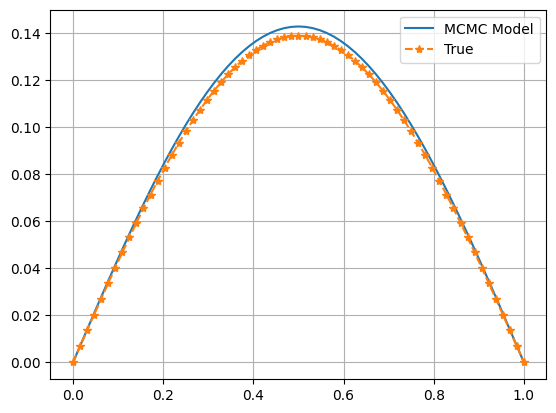

In [10]:
# Generating data: Numerical and analytical solution of heat equation
u = u0
u_up = u0
u_dn = u0
for tt in range(int(ttend)):
    k1 =    heat(u,nx,dx,K_obs_mean)
    k1_up = heat(u_up,nx,dx,K_obs_mean+K_obs_std)
    k1_dn = heat(u_dn,nx,dx,K_obs_mean-K_obs_std)

    k2 =    heat(u+k1*dt/2,nx,dx,K_obs_mean)
    k2_up = heat(u_up+k1_up*dt/2,nx,dx,K_obs_mean+K_obs_std)
    k2_dn = heat(u_dn+k1_dn*dt/2,nx,dx,K_obs_mean-K_obs_std)

    k3 =    heat(u+2*k2*dt-k1*dt,nx,dx,K_obs_mean)
    k3_up = heat(u_up+2*k2_up*dt-k1_up*dt,nx,dx,K_obs_mean+K_obs_std)
    k3_dn = heat(u_dn+2*k2_dn*dt-k1_dn*dt,nx,dx,K_obs_mean-K_obs_std)

    u =    u + 1/6*dt*(k1+4*k2+k3)
    u_up = u_up + 1/6*dt*(k1_up+4*k2_up+k3_up)
    u_dn = u_dn + 1/6*dt*(k1_dn+4*k2_dn+k3_dn)
u_MCMC_mean = u
u_MCMC_up = u_up
u_MCMC_dn = u_dn

# plotting "u_nu" and "u_an' at final time step
plt.figure()
plt.plot(x,u_MCMC_mean, label='MCMC Model')
plt.plot(x,u_nu, '--*', label='True')
plt.legend()
plt.grid(True)
plt.show()